In [172]:
# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Define the path of the shared folder (replace with your ID)
DATASET_DIR = '/content/drive/MyDrive/Colab Notebooks/RCC_WSIs'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [173]:
# 3) Collect metadata into a DataFrame
import os
import pandas as pd

records = []
for dirpath, dirs, files in os.walk(DATASET_DIR):
    for f in files:
        full = os.path.join(dirpath, f)
        try:
            size = os.path.getsize(full)
        except OSError:
            size = 0
        rel_dir = os.path.relpath(dirpath, DATASET_DIR)
        records.append({
            'subfolder': rel_dir if rel_dir != '.' else '/',
            'file_name': f,
            'extension': os.path.splitext(f)[1].lower(),
            'size_MB': size / 1024**2
        })

df = pd.DataFrame(records)

# 4) Summarize by subfolder, aggregating correctly
summary = df.groupby('subfolder').agg(
    n_files      = ('file_name',     'count'),
    total_MB     = ('size_MB', 'sum'),
    extensions   = ('extension',    lambda s: sorted(s.unique()))
).reset_index()

print(summary)

                  subfolder  n_files      total_MB  \
0                         /        1      0.000171   
1        Annotations_chromo       14   3445.012595   
2          Annotations_onco       26  16242.511722   
3                    CHROMO       12  43365.604111   
4                ONCOCYTOMA       16  49099.130724   
5                    README        5    964.136211   
6                     ccRCC       61  69983.051327   
7           ccRCC/ccRCC_xml       60      1.054395   
8                      pRCC       27  35282.477723   
9             pRCC/pRCC_xml       26      0.359133   
10                pre/ccRCC       65  48557.680746   
11  pre/ccRCC/pre_ccRCC_xml       65      1.619007   
12                 pre/pRCC       22  14906.510803   
13    pre/pRCC/pre_pRCC_xml       22      0.453692   

                             extensions  
0                               [.gdoc]  
1                   [.svs, .tif, .xlsx]  
2                   [.svs, .tif, .xlsx]  
3                    

Dataset analysis with GPT-4o

| Category                    | Folder                    | # files | Total (MB)  | Extensions                                  | Description & Use                                                                      |
| --------------------------- | ------------------------- | ------- | ----------- | ------------------------------------------- | -------------------------------------------------------------------------------------- |
| **Original Datasets**       | `/`                       | 1       | 0.0002      | `.gdoc`                                     | Description file (Google Doc).                                                      |
|                             | `CHROMO`                  | 12      | 43 365.6    | `.svs`                                      | Whole Slide Images of chromophobe tumors. Visualization with QuPath/ASAP.                      |
|                             | `ONCOCYTOMA`              | 16      | 49 099.1    | `.svs`                                      | Whole Slide Images of oncocytomas.                                                             |
|                             | `ccRCC`                   | 61      | 69 983.1    | `.scn`, `.py`                               | Whole Slide Images of clear-cell RCC (`.scn`); `wsi_manager.py` script                        |
|                             | `pRCC`                    | 27      | 35 282.5    | `.scn`, `.xlsx`                             | Whole Slide Images of papillary RCC; Excel sheet for patient correspondence                  |
|                             | `pre/ccRCC`               | 65      | 48 557.7    | `.scn`                                      | Additional "pre" patients for ccRCC (same structure as ccRCC)                         |
|                             | `pre/pRCC`                | 22      | 14 906.5    | `.scn`                                      | Additional "pre" patients for pRCC                                                      |
| **ROI Annotations**         | `Annotations_chromo`      | 14      | 3 445.0     | `.svs`, `.tif`, `.xlsx`                     | Multiresolution ROIs cropped from CHROMO; `.xlsx` list of patients/coordinates          |
|                             | `Annotations_onco`      | 26      | 16 242.5    | `.svs`, `.tif`, `.xlsx`                     | Multiresolution ROIs cropped from ONCO; `.xlsx` list of patients/coordinates            |
| **XML Metadata**            | `ccRCC/ccRCC_xml`         | 60      | 1.05        | `.xml`                                      | Region-of-interest files for ccRCC (define "pure" tumor areas)               |
|                             | `pRCC/pRCC_xml`         | 26      | 0.36        | `.xml`                                      | ROI files for pRCC                                                                   |
|                             | `pre/ccRCC/pre_ccRCC_xml` | 65      | 1.62        | `.xml`                                      | XML ROIs for pre/ccRCC folder                                                         |
|                             | `pre/pRCC/pre_pRCC_xml` | 22      | 0.45        | `.xml`                                      | XML ROIs for pre/pRCC folder                                                          |
| **Documentation and Scripts** | `README`                  | 5       | 964.1       | `.pickle`, `.py`, `.tif`, `.html`, `.ipynb` | Example notebook, HTML & Python WSI management script, pre-extracted crop pickle |

In [174]:
!apt update && apt install -y openslide-tools
!pip install openslide-python

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
35 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

In [175]:
import os
import pickle
import openslide
import numpy as np
import matplotlib.pyplot as plt
from wsi_manager import CropList, SectionManager

In [176]:
README_DIR = DATASET_DIR + "/README"
filepath_object = os.path.join(README_DIR, "H19-754-IHC-ccRCC_crop_obj.pickle")
with open(filepath_object, "rb") as handle:
    data = pickle.load(handle)

data is a CropList or similar object, with fields such as:

indexes: list of dictionaries with info for each crop

'mask': binary mask (e.g., tumor vs background)

'left', 'top': coordinates in the WSI

'size': size of the crop

'level': zoom level

'filepath_slide': source WSI file

In [177]:
#data.indexes

Segmented binary mask highlighting Regions of Interest (ROIs) within a histological tissue patch, in the context of the RCC Whole Slide Images (WSIs) dataset

(512, 512, 1)


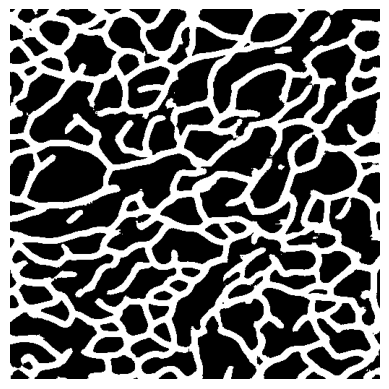

In [178]:
print(data.indexes[710]['mask'].shape)
data.indexes[710]['mask']

fig, ax = plt.subplots(1, 1)
mask = data.indexes[500]['mask'].copy()
mask[mask >= 0.3] = 255 #  You can change the thickness of the mask here
ax.imshow(mask,  cmap='gray')
ax.axis('off');

Cosa mostra l’immagine

*   Nero (0): aree non rilevanti, cioè background o tessuto escluso dalla ROI.

*   Bianco (255): contorni o aree che hanno superato la soglia di probabilità (≥ 0.3) nella maschera soft originale.

Visivamente, sembra mostrare:


*   strutture cellulari o glandulari, con pattern simili a setti fibrosi, membrane o pareti tra regioni.

*   la maschera evidenzia bordature: questo può derivare da:

  *   segmentazione automatica con soglia bassa (0.3), che tende a mantenere zone “frangiate”

  *  annotazioni a contorno o probabilità più alte nei bordi delle strutture




In [179]:
filepath_wsi = os.path.basename(data.indexes[500]['filepath_slide'])
print(filepath_wsi)  # Note that Windows see .scn files as tif, so you have to change filename
wsi = openslide.OpenSlide(os.path.join(README_DIR, "H19.754.IHC.ccRCC.tif"))
crop_corresponding_to_mask = wsi.read_region([data.indexes[500]['left'],
                                              data.indexes[500]['top']],
                                             data.indexes[500]['level'],
                                             [data.indexes[500]['size'],
                                              data.indexes[500]['size']])
print("Shape is 2000x2000: {} and we have also alpha channel".format(np.array(crop_corresponding_to_mask).shape))
# Resize to mask size (512x512)
crop_corresponding_to_mask_resized = np.array(crop_corresponding_to_mask.resize((512, 512)))

H19.754.IHC.ccRCC.scn
Shape is 2000x2000: (2000, 2000, 4) and we have also alpha channel


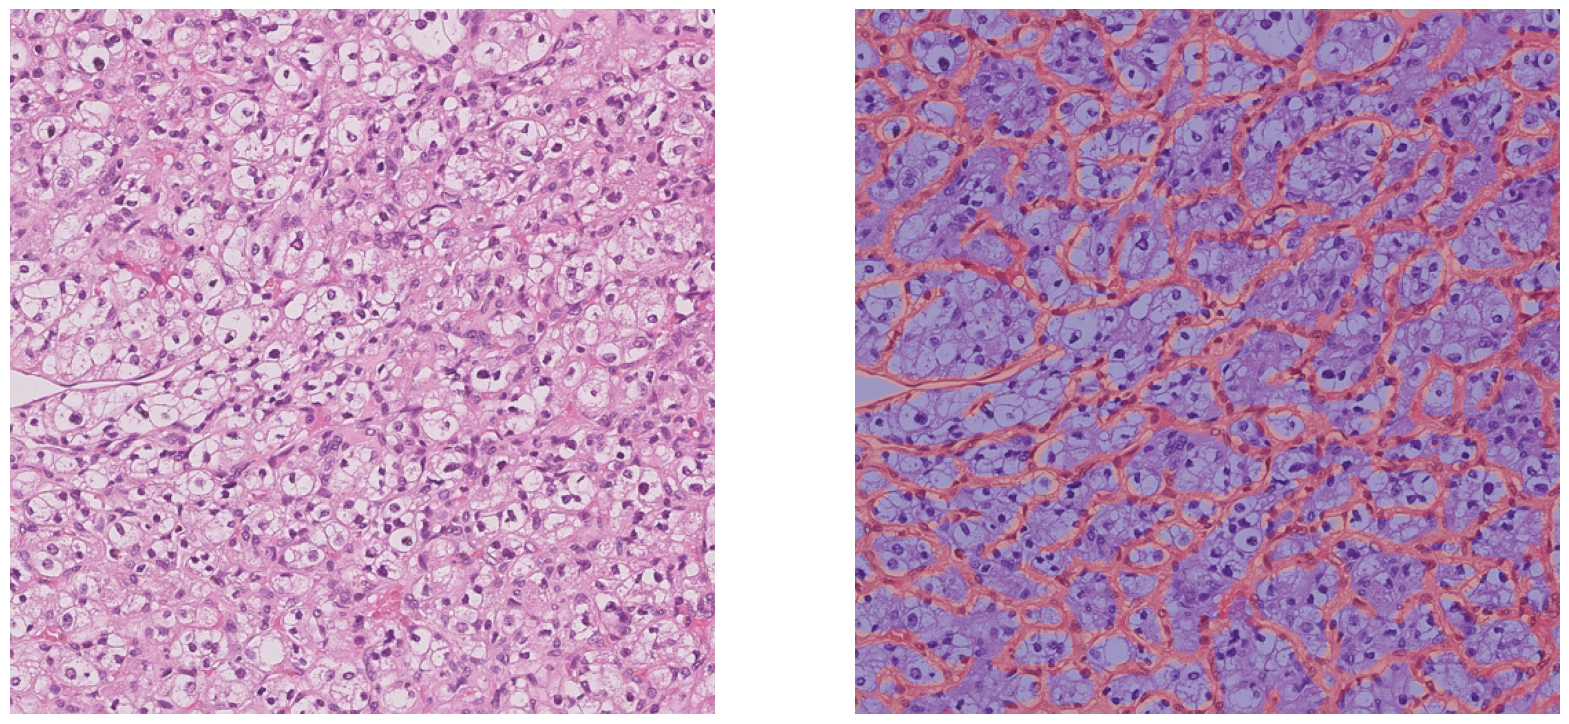

In [180]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[1].imshow(crop_corresponding_to_mask_resized)
ax[1].imshow(mask, cmap='jet', alpha=0.3)
ax[1].axis('off');
ax[0].imshow(crop_corresponding_to_mask_resized)
ax[0].axis('off');

## 🔍 Interpretation of the two images side-by-side

### 🖼 Left: **Original Image (Crop)**

*   This is a **crop** (initially 2000×2000 pixels, then resized to 512×512) taken from a WSI (`ccRCC`).
*   It displays histological tissue stained with the classic H&E (hematoxylin and eosin) method.
*   **Clear cells** are visible, which are characteristic of **clear cell RCC** (renal cell carcinoma).
*   It serves as a pure visual reference.

---

### 🖼 Right: **Image with Mask Overlay**

*   This is the same crop, but with a **binary mask overlay** applied using the **"jet" colormap**.
*   The mask is blended with the image using an `alpha=0.3` value, making it appear **transparent**.
*   The highlighted areas (e.g., in red) indicate regions marked as "positive" tissue (ROI) by the **model or annotator**.